$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\transp}{\mathrm{T}}$
$\newcommand{\jR}{\mathcal{R}}$

# B. The LGG Algorithm

[SpaceEx](http://spaceex.imag.fr/) is a verification platform for hybrid systems. The basic functionality is to compute the set of reachable sets of a system. Currently, SpaceEx accepts piecewise-linear systems only. The standard way to deal with nonlinearities is to perform a local linearization of the system's dynamics, a method called *hybridization* in this area.  
 
The [LGG (Le Guernic-Girard)](http://ljk.imag.fr/membres/Antoine.Girard/Publications/cav2009.pdf) is an algorithm implemented in SpaceEx (along with more recent methods such as [STC](http://spaceex.imag.fr/sites/default/files/frehse_stc_lgg_comp.pdf)).  

In this worksheet we implement the linear part of the LGG algorithm of Le Guernic and Girard, described in [this paper](http://www-ljk.imag.fr/membres/Antoine.Girard/Publications/na-hs.pdf), and make a test in the following simple example. 

## 1. Hybridization

The method known as hybridization consists in performing a local linearization over a set of positions in state-space. 

This is an illustration of the hybridization technique, from [O. Maler, Computing Reachable Sets: An Introduction](http://www-verimag.imag.fr/~maler/Papers/reach-intro.pdf).
![alt text](https://github.com/mforets/SMC-and-set-based-computations/blob/master/fig/hybridization.png?raw=true)

## 2. A two-dimensional LTI example 

Consider the system
$$
\begin{pmatrix}
\dot{x}_1 \\ \dot{x}_2
\end{pmatrix} = \begin{pmatrix} -1  & -4 \\ 4 & -1 \end{pmatrix} \begin{pmatrix}
x_1 \\ x_2
\end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \end{pmatrix}.
$$
Let $\mathcal{X}_0 = [0.9,1.1]\times [-0.1,1.1]$ be the initial set. Suppose that $u_1(t),u_2(t) \in B_\infty(0,\mu)$ for all $t\geq 0$, with $\mu=0.05$. What is the set of states reachable at time $T=2$? This two-dimensional example appears in [Gir05](http://www-ljk.imag.fr/membres/Antoine.Girard/Publications/hscc2005.pdf).

## 2.1. Numerical integration 

The solution of the [LTI](https://en.wikipedia.org/wiki/LTI_system_theory) system $\dot{x}=Ax + u$ is
$$
x(t) = e^{At}x_0 + \int_0^t e^{A(t-s)}u(s) ds,
$$
where $x=(x_1,x_2)^\transp$ and $u = (u_1, u_2)^\transp$. Below we numericlly solve this integral for different values of the initial condition. Let us assume that $u_1(t) = \mu\cos t$ and $u_2(t) = \mu \sin t$, with $\mu = 0.05$.

*Exercise*. Compute the numerical integral, for different values of $x_0 \in \mathcal{X}_0 = [0.9,1.1]\times [-0.1,1.1]$. 
*Hint:* Use sage function numerical_integral.

## 3. Efficient algorithm for the computation of polyhedral approximations of the reachable set 

This corresponds to Section 4 of [LGG09](http://www-ljk.imag.fr/membres/Antoine.Girard/Publications/na-hs.pdf). Consider the LTI system
$$
\dot{x}(t) = Ax(t) + Bu(t),
$$
with $u(t) \in U \subseteq \R^{d'}$ a compact convex set; $A$ and $B$ are matrices of appropriate dimensions (we assume that the state-space is $n$-dimensional and over the real field). It is convenient to *homogeneize* the system by defining the set $V=BU \subset \R^n$, and consider the equivalent system
$$
\dot{x}(t) = Ax(t) + v(t),
$$
with $v(t) \in V$. 

**Definition**. The set of states reachable at time $s>0$ from states in a given subset $X \in \R^n$ is
$$
\jR_s(X) := \{ x(s) : \dot{x}=Ax+v,~v\in V,~\forall t \in [0,s]\text{ and } x(0) \in X \}.
$$
The reachable set on the time interval $[s,s']$ is defined as 
$$
\jR_{[s,s']}(X) := \bigcup\limits_{t\in[s,s']}\jR_t(X).
$$

This object is also often called *reach-pipe*. 

**Objective**. The goal is to approximate the reach-pipe, $\jR_{[0,T]} (X_0)$, given an initial set $X_0$ and a finite time horion $T>0$.

### 3.1. Time-discretization scheme

The approach is based on the discretization of time. Let $\tau = T/N$ be the time step. Then,
$$
\jR_{[0,T]} (X_0) = \bigcup\limits_{i=0}^{N-1} \jR_{[i\tau, (i+1)\tau]} (X_0).
$$
The idea is to compute over-approximations of the sets $\jR_{[i\tau, (i+1)\tau]} (X_0)$, and the desired result will be their union.

### 3.2. Main result 

The idea is that the reachable set $\jR_{[0,T]} (X_0)$ can be approximated by the union of convex sets $\Omega_0 \cup \ldots \cup \Omega_{N-1}$. The sequence of approximants is built as
$$
\Omega_0 := CH\left(X_0, e^{\tau A}X_0 \oplus \tau V \oplus \alpha_{\tau} B \right),
$$
and
$$
\Omega_{i+1} := CH\left( X_0, e^{\tau A}\Omega_i \oplus \tau V \oplus \beta_{\tau} B\right),\qquad i = 0,\ldots,N-2.
$$
In these definitions, $\alpha_{\tau}$ and $\beta_{\tau}$ have explicit formulas which are such that over-approximation is ensured. The main result is that the error bound can be made arbitrarily small by choosing $\tau$ small enough. More precisely (see Theorem 1 in [LGG09](http://www-ljk.imag.fr/membres/Antoine.Girard/Publications/na-hs.pdf) for details), for all $i=0,\ldots,N-1$, it holds that
$$
d^H(\Omega_i, \jR_{[i\tau,(i+1)\tau]} (X_0)) \leq \tau e^{T||A||} \left( \dfrac{||A||}{4} D_{X_0} + \tau ||A||^2  R_{X_0} + e^{\tau ||A||} R_V \right), 
$$
where $R_{X_0}$ and $R_V$ are the radius of $X_0$ and $V$ respectively, and $D_{X_0}$ is the diameter of $X_0$. Note that the error bound for the Hausdorff distance is in $\mathcal{O}(\tau)$.

### 3.3. Implementation of the algorithm

The initial set that we are given is $\mathcal{X}_0 = [0.9,1.1]\times [-0.1,1.1] = B_\infty([1,0],0.1)$.

In [129]:
reset()

In [130]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
load("../Library/polyFunctions.sage")
load("../Library/matrixNorms.sage")

# LTI system
n = 2
A = np.array([[-1, -4], [4, -1]], dtype=float) 
B = np.array([[1, 0], [0, 1]], dtype=float)

# time horizon, t0=0 is assumed
T = 2

# input domain U
mu = 0.05
U = Binfty(center = [0,0], radius = mu)

# initial condition 
X0 = Binfty(center = [1,0], radius = 0.1)

# time discretization 
tau = 1e-1
N = 20 # in the analysis, T = N*tau
# compute range of the input under B, V = BU
V = matTimesPol(B, U) 

# compute matrix exponential 
Phi_tau = expm(np.multiply(A, tau))

# compute exp(tau*A)X0
expX0 = matTimesPol(Phi_tau, X0)

# compute the initial over-approximation
tau_V = matTimesPol(tau*np.identity(n), V)

# compute the bloating factor 
Ainfty = matinftynorm(A)
RX0 = polyRadius(X0)
RV = polyRadius(V)

unitBall = Binfty(center = [0,0], radius = 1)
alpha_tau = (exp(tau*Ainfty) - 1 - tau*Ainfty)*(RX0 + RV/Ainfty)
alpha_tau_B = matTimesPol(alpha_tau*np.identity(n), unitBall)

# compute the first element of the approximating sequence, Omega_0
aux = expX0.Minkowski_sum(tau_V)
Omega0 = X0.convex_hull(aux.Minkowski_sum(alpha_tau_B)) 

Here $\Omega_0$ is an over-approximation $\jR_{[0,\tau]}(X_0)$. The idea is the following:
1. $e^{\tau A}X_0 \oplus \tau V$ is an approxmation of the reachable set at time $\tau$;
2. a *bloating* operation followed by a convex hull operation gives an approxmation of $\jR_{[0,\tau]}(X_0)$. 
3. $\alpha_\tau$ (the bloating factor) is chosen to ensure over-approxmation. 

Let us check $\Omega_0$:

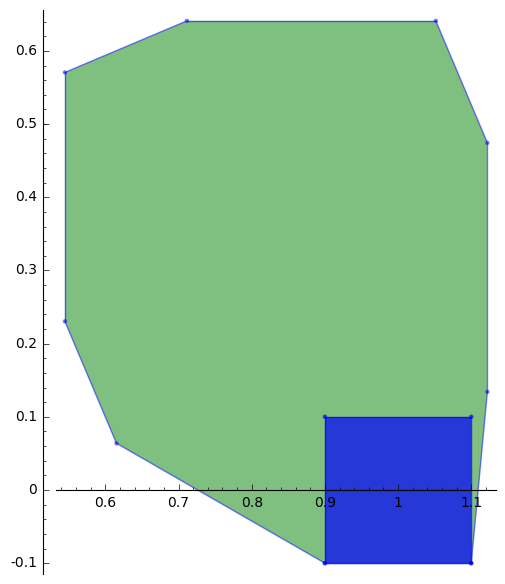

In [112]:
Omega0.plot(alpha=0.5) + X0.plot(alpha=0.7,color='blue')

In [131]:
# build the Omega_i
beta_tau = (exp(tau*Ainfty) - 1 - tau*Ainfty)*(RV/Ainfty)
beta_tau_B = matTimesPol(beta_tau*np.identity(n), unitBall)
W_tau = tau_V.Minkowski_sum(beta_tau_B) 

# receives a direction d, and outputs the support function rho_i of Omega_i at d
def Omega_i_supports(d, N):
    r = list()
    s = list()
    rhoi = list()
    
    r.append(d)
    s.append(0)
    rhoi.append(supp_fun_polyhedron(d,Omega0,showOutput=0)[0])
    
    for i in [0..N-2]:
        r.append(np.dot(Phi_tau.transpose(),r[i]))
        s.append(s[i] + supp_fun_polyhedron(r[i], W_tau,showOutput=0)[0])
        rhoi.append(s[i+1] + supp_fun_polyhedron(r[i+1], Omega0, showOutput=0)[0])
    
    return rhoi

In [132]:
# define the directions 

# directions at random
#import random
#k=4
#theta = [random.uniform(0, 2*pi.n(digits=5)) for i in range(k)]
#d = [vector(RR,[cos(theta[i]), sin(theta[i])]) for i in range(k)]

# specify directions 
#theta = [0,pi/2,pi,3*pi/2] # box
theta = [i*pi/4 for i in [0..7]] # octagon

dList = [vector(RR,[cos(theta[i]), sin(theta[i])]) for i in range(len(theta))]
dArray = np.array(dList)

# number of directions
k = len(dArray)

# compute family of support functions
Omega_i_Family_SF = list()
for i in range(len(dArray)):
    d = dArray[i]
    Omega_i_Family_SF.append( Omega_i_supports(d, N) ) 

### 3.5. Test of the implementation

It remains to build the family of approximating polyhedrons, and plot the result.

In [133]:
# build each polyhedron using the support functions over-approximation
# we have N polyhedrons
Omega_i_Poly = list()
for i in range(N): #run over polytopes
    
    # for each polyhedra, I have to use all directions that I know
    A = matrix(RR,k,n); b = vector(RR,k)
    for j in range(k): #run over directions
        s_fun = Omega_i_Family_SF[j][i]
        A.set_row(j, dList[j])
        b[j] = s_fun
        
    Omega_i_Poly.append( polytopeFromHrep(A, b) ) 

In [134]:
# plot the result
myFig = Graphics()

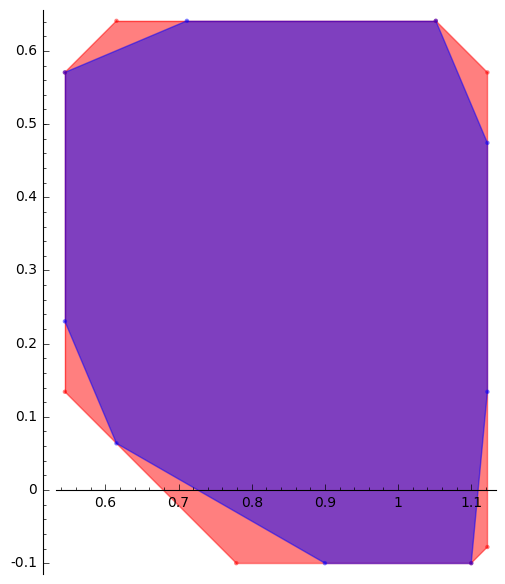

In [140]:
# sanity check
myFig = Omega_i_Poly[0].plot(alpha=0.5,color='red') + Omega0.plot(alpha=0.5,color='blue')
myFig.show()
# we don't actually expect exact matching (because Omega0 is being partially constructed with its support function); unless we take sufficient number of directions

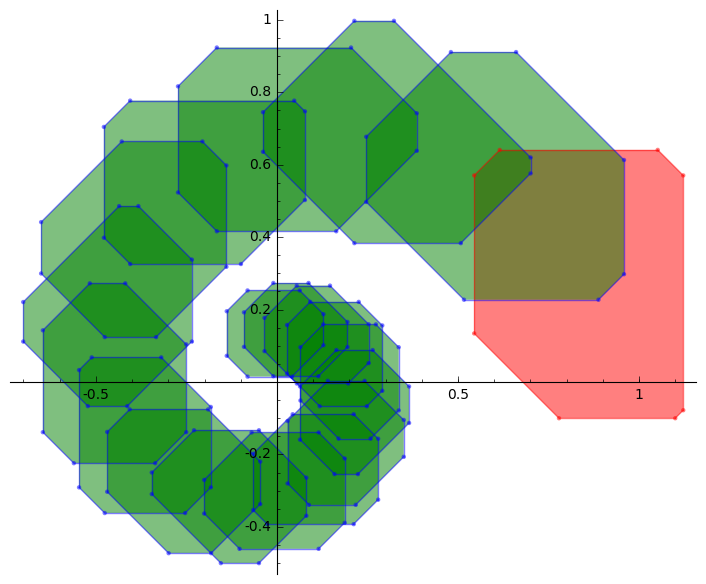

In [137]:
myFig = Omega_i_Poly[0].plot(alpha=0.5,color='red') + sum(Omega_i_Poly[i].plot(alpha=0.5) for i in [1..N-1])
myFig.show()